# todo
 _ visualize trips
 - stats to calculate visualize
     - duration 
     - distribution over time
     - distribution by location
     - start to end correlations ? 
     - weekday pairs
     
     

In [5]:
#!pip install geopandas
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import descartes
import geopandas as gpd
from shapely.geometry import Point, Polygon, LineString
crs = {'init': 'epsg:4326'}

#from datetime import datetime as dt


In [6]:
#get previously processed files
station_geo = gpd.read_file('station_info.csv', GEOM_POSSIBLE_NAMES="geometry", KEEP_GEOM_COLUMNS="NO")



city_to_region = pd.read_csv('city_region.csv')  #table of region ids by city

trips = pd.read_csv('2017-fordgobike-tripdata.csv')
print(trips.shape)



(519700, 13)


In [7]:
#drop redundant cols and add features

trips['duration_min'] = trips.duration_sec.apply(lambda s: s /60) #seconds is not friendly 
trips.drop(labels=['start_station_name','end_station_name'],axis=1) #dont need these now can, join with station data later
trips.drop(labels=['duration_sec'],axis=1, inplace=True) #dont need anymore
dtobj =  pd.DatetimeIndex(trips['start_time'])

In [8]:

#we will want to work with day of week as well as group trips by time:
trips['year'] = dtobj.year
trips['month'] = dtobj.month
trips['day'] = dtobj.day
trips['dow'] = dtobj.day_name()  #day of week in english    
trips['hour'] = dtobj.hour
trips['time'] = dtobj.time

trips.drop(labels=['start_time','end_time'], axis=1, inplace=True)


In [9]:
#try to calculate straight line dist between start and end points using haversine formula
def haversine_distance(lat1, lon1, lat2, lon2):
   r = 6371
   phi1 = np.radians(lat1)
   phi2 = np.radians(lat2)
   delta_phi = np.radians(lat2 - lat1)
   delta_lambda = np.radians(lon2 - lon1)
   a = np.sin(delta_phi / 2)**2 + np.cos(phi1) * np.cos(phi2) *   np.sin(delta_lambda / 2)**2
   res = r * (2 * np.arctan2(np.sqrt(a), np.sqrt(1 - a)))
   return np.round(res, 2)
def hd(s):                                #need to accept series
   r = 6371
   phi1 = np.radians(s[0])
   phi2 = np.radians(s[2])
   delta_phi = np.radians(s[2] - s[0])
   delta_lambda = np.radians(s[3] - s[1])
   a = np.sin(delta_phi / 2)**2 + np.cos(phi1) * np.cos(phi2) *   np.sin(delta_lambda / 2)**2
   res = r * (2 * np.arctan2(np.sqrt(a), np.sqrt(1 - a)))
   return np.round(res, 2)   #in km

hd(trips[['start_station_longitude','start_station_latitude',
   'end_station_longitude','end_station_latitude']].iloc[0])
test = trips[['start_station_longitude','start_station_latitude',
   'end_station_longitude','end_station_latitude']].iloc[0]
#verify that my adapation works.. 
haversine_distance(test[0],test[1],test[2],test[3]) == hd(trips[['start_station_longitude','start_station_latitude',
   'end_station_longitude','end_station_latitude']].iloc[0])

trips['dist_km'] = trips[['start_station_longitude','start_station_latitude',
   'end_station_longitude','end_station_latitude']].apply(hd,axis=1)

In [10]:
#calculate a speed factor, using straight line dist and trip duration (this is not actual bike velocity)
##takes a while
trips['speedf'] =  trips[['dist_km','duration_min']].apply(lambda x : x[0] / x[1]/60, axis=1)

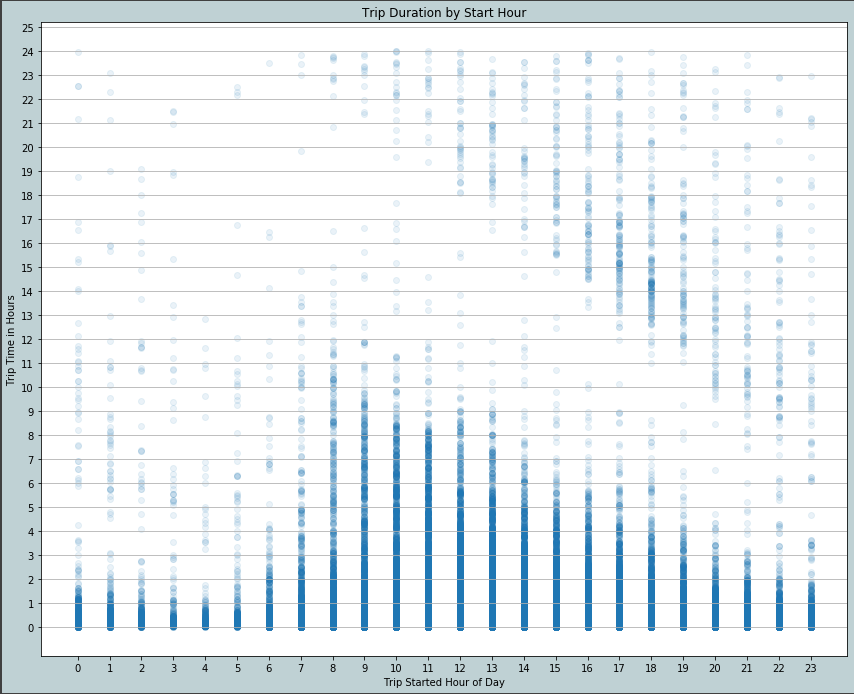

"\nslider_alpha= Slider(ax_slider,\n                     'a',        #slider param\n                     0.0,       #min\n                     .5,        #max\n                     valinit=a_init) # startin alpha\n\ndef update(a):\n    ax1.set_alpha(a)\n    fig.canvas.draw_idle()\n\nslider_alpha.on_changed(update)\nax1.set_alpha(1)\nfig.canvas.draw_idle()\n"

In [68]:
#plot duration stats
%matplotlib inline
#from matplotlib.widgets import Slider # make interacive?

y=trips.duration_min/60 #change to hours 
x=trips.hour
a_init =.09

fig= plt.figure(figsize=(14,11),
                frameon=True,
                facecolor='#BFD1D4',
                edgecolor='#404040',
                linewidth=3)
#ax1 = plt.subplot(111)
ax1= fig.add_axes((.1,.1,.8,.8))
#axcolor = 'lightgoldenrodyellow'
#ax_slider = plt.axes([0.25, 0.15, 0.65, 0.03], facecolor=axcolor)
#plt.subplots_adjust(left=0.25, bottom=0.25)## make space for slider

ax1.scatter(x,y, alpha=a_init)

ax1.set_title('Trip Duration by Start Hour')
ax1.set_xticks(range(0,24,1))    
ax1.set_yticks(range(0,26,1))
ax1.set_xlabel('Trip Started Hour of Day')
ax1.set_ylabel('Trip Time in Hours')
ax1.grid(True, axis='y')

plt.savefig('duration_stats.jpg',facecolor=fig.get_facecolor(),edgecolor=fig.get_edgecolor())
plt.show()


# Discussion
 The preceding plot certainly presents an interesting pattern: what looks like a fairly normal distribution centered around 

In [ ]:
fig= plt.figure(figsize=(15,10))

ax2 = plt.subplot(221)
ax3 = plt.subplot(222)
ax4 = plt.subplot(223)
ax5 = plt.subplot(224)

ax2.scatter(trips.hour, trips.dist_km, alpha =.07)
ax2.set_title('trip distance vs Hour of Day')

ax3.scatter(trips.duration_min/60, trips.dist_km, alpha =.09)
ax3.set_title('trip duration vs distance (km/hr)')
ax3.set_ylim(0,40) #dont look at unreasonable values
ax3.set_ylabel('distance (km)')
ax3.set_xlabel('trip duration (hrs)')
ax3.grid(True)
ax4.scatter(trips.end_station_longitude, trips.dist_km, alpha =.07)
ax5.scatter(trips.dist_km, trips.duration_min, alpha =.07)
plt.show()


# Pricing Information:
The current pricing scheme is located here: 

    * [E-bike Pricing](https://help.baywheels.com/hc/en-us/articles/360039662872-Ebike-pricing)
    * [Classic Bike Pricing](https://www.lyft.com/bikes/bay-wheels/pricing)
    
It was used to create the costing functions below, allowing us to get an idea of what that average revenue from a rental could be. 


In [ ]:
#current pricing source https://help.baywheels.com/hc/en-us/articles/360039662872-Ebike-pricing
# https://www.lyft.com/bikes/bay-wheels/pricing

def member_price(duration_min):
    return int((duration_min - 45 ) / 15) * 3 # As a member, you’ll receive unlimited 45-minute trips on our Classic bikes and discounted ebike per minute pricing. If you keep a Classic bike out longer than 45 minutes at a time, it’s an extra $3 per additional 15 minutes
def customer_price(duration_min):
    return 2 + int(duration_min - 30) * 3   #$2 for one ride up to 30 minutes - perfect for getting you where you need to go. If your ride lasts longer than 30 minutes, it’s an extra $3 per additional 15 minutes. Available in app only. Ebike pricing applies to ebike trips

def member_ebike(duration_min):
    return duration_min * 0.15 + member_price(duration_min)
def customer_ebike(duration_min):
    return duration_min * 0.20 + customer_price(duration_min)

def tripcost(member,ebike,dur):
    if member & ebike:
        return member_ebike(dur)
    elif member & ~ebike:
        return member_price(dur)
    elif ~member & ebike:
        return customer_ebike(dur)
    else:  
        return customer_price(dur)


In [ ]:
#started to generate the geometry ...
startpoints= gpd.points_from_xy(trips.start_station_longitude, trips.start_station_latitude)
endpoints= gpd.points_from_xy(trips.end_station_longitude, trips.end_station_latitude)

trips_geo = gpd.GeoDataFrame(trips.copy(),crs=crs,geometry= startpoints)
trips_geo['endpoints'] = endpoints
#interesting. quite a few return to same location ... ##will need to have a look

trips_geo.rename(columns={'geometry': 'startpoints'}, inplace=True)
trips_geo['tripline'] = trips_geo[['startpoints','endpoints']].apply(lambda x : LineString([x['startpoints'], x['endpoints']]),axis=1 )
trips_geo.set_geometry('tripline', inplace=True)

In [ ]:
#debug remove
test= trips_geo[['startpoints','endpoints']]
ls = test.apply(lambda p : LineString([p['startpoints'],p['endpoints']]),axis=1)
ls[0]


In [ ]:
#a look at trips that start and end at the same station
# these trips may need to be excluded as they seem to have some extreme values

zero_dist = trips.dist_km == 0

print(trips[zero_dist].duration_min.describe([.25,.5,.95]))
trips.duration_min.describe()
trips[~zero_dist].duration_min.describe([.25,.5,.95])  ## maybe we can toss trips over 

fig= plt.figure(figsize=(12,12),frameon=True, facecolor='#F7F7F7')
ax1  = plt.subplot(221)
ax2  = plt.subplot(222)

x=trips[zero_dist].start_station_id
y=trips[zero_dist].duration_min
dur_mean = y.mean()
dur_std = y.std()
ax1.set_title('All Zero distance trips\n by station_id')
ax1.set_xlabel('Station Id')
ax1.set_ylabel('Duration in Min')
ax1.hlines(y.mean()+y.std(),0,x.max(), colors='r', linestyles='dashed',label ='zero dist 1 std')
ax1.text(40,dur_mean + 2, 'mean duration is about 64 min')
ax1.text(40,dur_mean+dur_std+1, '1 SD')
ax1.hlines(y.mean()+3*dur_std,0,x.max(), colors='r', linestyles='dotted',label ='zero dist 3 std')
ax1.text(40,dur_mean+3*dur_std+2, '3 SD')


ax1.hlines(y.mean(),0,x.max(), colors='r', label ='zero dist mean')
ax1.hlines(y.mean(),0,x.max(), colors='r', label ='zero dist mean')
ax1.scatter(x,y, alpha=.025)


lbound = 5 <= trips[zero_dist].duration_min   # dur_mean-2*dur_std <= trips[zero_dist].duration_min
ubound = trips[zero_dist].duration_min <= dur_mean+1.5*dur_std
bounded = lbound & ubound
zd_trips = trips[zero_dist][bounded]

ax2.set_title('Histogram of zero dist trips\n after excluding outliers')
ax2.hist(zd_trips.duration_min, bins= 300,  density=True, stacked=True)


ax2.vlines(zd_trips.duration_min.mean(),0, .05, colors='g',linestyles ='dashed')
ax2.text(zd_trips.duration_min.mean()+ 8 ,.02, 'mean of this masked dataset\nis still skewed by long tail')
ax2.set_ylabel('# of trips')
ax2.set_xlabel('Duration in Min')
#compare to non-zero dist trips.//
ax3  = plt.subplot(223)
ax4  = plt.subplot(224)

x=trips[~zero_dist].start_station_id
y=trips[~zero_dist].duration_min
dur_mean = y.mean()
dur_std = y.std()
ax3.set_title('Non Zero distance trips\n by station_id')
ax3.set_xlabel('Station Id')
ax3.set_ylabel('Duration in Min')
ax3.hlines(y.mean()+y.std(),0,x.max(), colors='r', linestyles='dashed',label ='zero dist 1 std')
ax3.text(40,dur_mean + 2, 'mean duration is about 64 min')
ax3.text(40,dur_mean+dur_std+1, '1 SD')
ax3.hlines(y.mean()+3*dur_std,0,x.max(), colors='r', linestyles='dotted',label ='zero dist 3 std')
ax3.text(40,dur_mean+3*dur_std+2, '3 SD')


ax3.hlines(y.mean(),0,x.max(), colors='r', label ='zero dist mean')
ax3.hlines(y.mean(),0,x.max(), colors='r', label ='zero dist mean')
ax3.scatter(x,y, alpha=.025)

#hist of non zero dist trips after discarding outliers

dz_trips =  trips[~zero_dist].duration_min
lbound = 5 <= dz_trips  # dur_mean-2*dur_std <= trips[zero_dist].duration_min
ubound = dz_trips <=  dz_trips.mean()+1.5* dz_trips.std()
bounded = lbound & ubound

x=  trips[~zero_dist][bounded].duration_min

ax4.set_title('Histogram of non-zero dist trips\n after excluding outliers')
ax4.hist(x, bins= 300, density=True, stacked=True)
ax4.vlines(x.mean(),0, .1, colors='g',linestyles ='dashed')
ax4.text(x.mean()+ 8 ,.06, 'mean of this masked dataset')
ax4.set_ylabel('# of trips')
ax4.set_xlabel('Duration in Min')
plt.savefig('eda_zero_dist_trips.jpg')
plt.show()
print('masked nonzero distance trips' , x.describe([.25,.5,.95]))
#one last scatter by day of week

fig= plt.figure(figsize=(12,6),frameon=True, facecolor='#F7F7F7')
ax1  = plt.subplot(121)
x=trips[zero_dist].day
y=trips[zero_dist].duration_min
dur_mean = y.mean()
dur_std = y.std()
ax1.set_title('All Zero distance trips\n by day of week')
ax1.set_xlabel('day' )
ax1.set_ylabel('duration')
ax1.hlines(y.mean()+y.std(),0,x.max(), colors='r', linestyles='dashed',label ='zero dist 1 std')
ax1.text(40,dur_mean + 2, 'mean duration is about 64 min')
ax1.text(40,dur_mean+dur_std+1, '1 SD')
ax1.hlines(y.mean()+3*dur_std,0,x.max(), colors='r', linestyles='dotted',label ='zero dist 3 std')
ax1.text(40,dur_mean+3*dur_std+2, '3 SD')


ax1.hlines(y.mean(),0,x.max(), colors='r', label ='zero dist mean')
ax1.hlines(y.mean(),0,x.max(), colors='r', label ='zero dist mean')
ax1.scatter(x,y, alpha=.025)

## day vs station
ax2  = plt.subplot(122)

x=trips[zero_dist].start_station_id
y=trips[zero_dist].day
ax2.set_title('All Zero distance trips\n by day of week')
ax2.set_xlabel('start station' )
ax2.set_ylabel('day')
ax2.scatter(x,y, alpha=.025)
plt.show()
station_geo.index
'''##conclusion : the dataset has some issues with outlier data. its not clear why there are some many extreme 
values for trip duration. Its possible that there is measurement erorr caused by bikes losing connectivity before
the end of the trip. given the theoretical costs associated with these trips, its unlikely that they represent 
actual trip durations. Finallly when we look at the zero distance trips by station, we can see that there are 
definite patterns. Some stations have a much higher incidence. These stations are likely to correlate with busy downtown
locations, or locations that have a problem with bikes going awol.
since our main line of inquiry is 'where are they going, its interesting to see that so
many trips return to their starting station, these dont give us much to analyse so other than noting their prevalence
we will ignore them from here out'''

In [ ]:
#stations with most zero dist trips 

biggest_zeros =trips[zero_dist][[
    'start_station_id',
    'start_station_name',
    'duration_min']].reset_index().groupby(by=['start_station_id',
                                               'start_station_name']).agg({'duration_min': 'mean',
                                                                           'index': 'count'}).sort_values('index',ascending=False).head(50)


In [ ]:
station_geo.set_index('station_id', inplace=True)
trips_geo.set_index('start_station_id',inplace=True)
regionSF = station_geo['region_id'] == '3'  #condition
station_geo[regionSF].index  #index is all station ids in region 3(SF)


In [ ]:
#going to start slimming down our geo dataframe. we want to look at only trips that start in SF
#we also want to exclude trips that start and end at the same station

start_in_SF = trips_geo.index.isin(station_geo[regionSF].index)  #c
sftrips =  trips_geo[start_in_SF].reset_index()
zerodist = sftrips.start_station_id == sftrips.end_station_id
sftrips = sftrips[zerodist]

In [ ]:
sftrips.head(1)

In [ ]:
#lets get the columns organized:

geomcols = ['startpoints','endpoints','tripline']
datecols= ['time']
numcols = ['duration_min','start_station_latitude','start_station_longitude', 
           'end_station_latitude', 'end_station_longitude', 
           'dist_km', 'speedf', 'year', 'month','day']
catcols =    ['start_station_id','end_station_id'
              'user_type','bike_id','dow']
dropcols = ['start_station_latitude','start_station_longitude','end_station_latitude', 'end_station_longitude']
for c in catcols:
    sftrips[c] = sftrips[c].astype('category')
    
sftrips.drop(labels=dropcols, axis=1, inplace=True)



In [ ]:
reorder = ['bike_id', 'user_type','start_station_id','end_station_id','duration_min', 'dist_km', 'speedf','dow', 'year',
       'month', 'day',  'hour', 'time', 'start_station_name', 
       'end_station_name', 'startpoints', 'endpoints', 'tripline']
sftrips = sftrips[reorder]
sftrips.head()


In [ ]:
## generate an arc linestring to plot the routes 
import scipy.interpolate # to ctop
coords = np.array([[0, 0], [25, 10], [50, 50]])  ##test

def curveline(start,end,x):
    ''' where start,end are point objects, and x is a scalar that perturbs the straight
    line between the two points, returns a LineString containing the curve'''
    #mid = 
    coords = np.array([start,mid, end])
    f = scipy.interpolate.interp1d(coords[:, 0], coords[:, 1], kind='quadratic')
    new_x = np.linspace(np.min(coords[:, 0]), np.max(coords[:, 0]), 10)
    new_y = f(new_x)
    new_coords = np.vstack([new_x, new_y]).T

sftrips['tripline'].shape

sf_proper = station_geo.region_id == '3'
station_geo[sf_proper]
numcols = ['lon','lat']
for n in numcols:
    station_geo[n] =station_geo[n].astype(float)
    
    ##debugging
station_geo[sf_proper].dtypes
print(sftrips.tripline.iloc[0:1])
type(sftrips)
print (xl,xr,yb,yt)
type(sftrips.tripline)
sftrips.tripline.plot()

In [ ]:
#plot 1 trip on map
#load the streetmap
fig = plt.figure(figsize=(12,12))
ax1 = plt.subplot()

map = gpd.read_file('geo/bayarea/tl_2019_06075_roads.shp')
xl = station_geo.lon.min() - .005
xr = station_geo[sf_proper].lon.max() + .005
yb =  station_geo[sf_proper].lat.min() - .005
yt =  station_geo[sf_proper].lat.max() + .005
ax1.set_xlim(xl,xr)
ax1.set_ylim(yb,yt)
map.plot(ax=ax1, alpha= 0.5, color='grey')
title = 'plot of 100 sf trips'
ax1.set_title(title)
sftrips.plot(ax=ax1, color='blue') #plot the geoseries
sftrips['startpoints'].plot(ax=ax1, color='green')
plt.show()

In [ ]:
total_bikes = trips.bike_id.count()
bybike = trips.groupby('bike_id')
trips.reset_index().groupby(by=['bike_id', 'start_station_name','end_station_name']).count()

In [ ]:
pairs = trips_geo.copy()
pairs =pairs[['start_station_id','end_station_id','duration_min','time','month','dow']]
pairs = pairs.dropna(axis=0, how='all')
pair_summary = pairs.groupby(['start_station_id',
                              'end_station_id']).agg({'duration_min': ['mean','min','max', 'std'], 'time': 'count'}).dropna(axis=0, how='all')
pair_summary.shape
